In [135]:
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [136]:
def generate_train(n: int = 20):
    np.random.seed(100)
    dist = np.random.uniform(0, 1, size=n)
    x = np.random.uniform(0, 1, size=n)
    X = np.hstack([dist.reshape(-1, 1), x.reshape(-1, 1)])
    noise = np.random.normal(0, 0.1, n)

    w = 3
    b = 1
    y = ((1 / (np.exp(-w * (x + noise) + b) + 1)) > 0.5).astype(int)
    return X, y

In [137]:
X, y = generate_train(20)

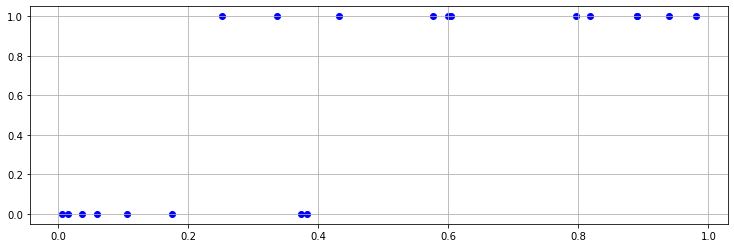

In [51]:
plt.figure(figsize=(12.5, 4))
plt.scatter(X[:, 1], y, color="b")
plt.grid()

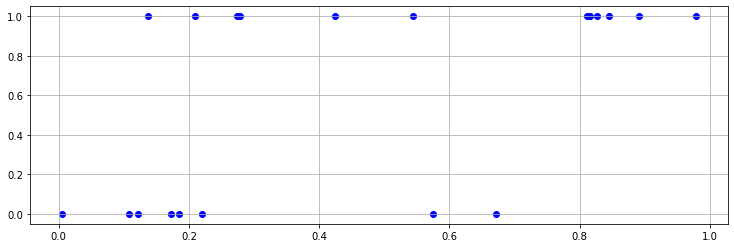

In [53]:
plt.figure(figsize=(12.5, 4))
plt.scatter(X[:, 0], y, color="b")
plt.grid()

In [54]:
lr = LogisticRegression()
lr.fit(X, y)

LogisticRegression()

In [55]:
lr.coef_

array([[0.96562768, 1.63770781]])

In [83]:
tau = pm.Uniform("tau", 0, 20)
w_dist = pm.Normal("w_dist", 0, 0.001, value=0)
w_x = pm.Normal("w_x", 0, 0.001, value=0)
bias = pm.Normal("bias", 0, 0.001, value=0)
n = len(X)

@pm.deterministic
def p(dist=X[:, 0], x=X[:, 1], w_dist=w_dist, w_x=w_x, tau=tau, bias=bias):
    w_dist = (dist >= tau) * w_dist
    w_x = np.ones(n) * w_x
    return 1 / (1 + np.exp(-w_x * x - w_dist * dist + bias))

obs = pm.Bernoulli("obs", p, value=y, observed=True)

C:\ProgramData\Anaconda3\lib\site-packages\pymc\MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 50000 of 50000 complete in 7.8 secPlotting w_x
Plotting bias
Plotting tau
Plotting w_dist


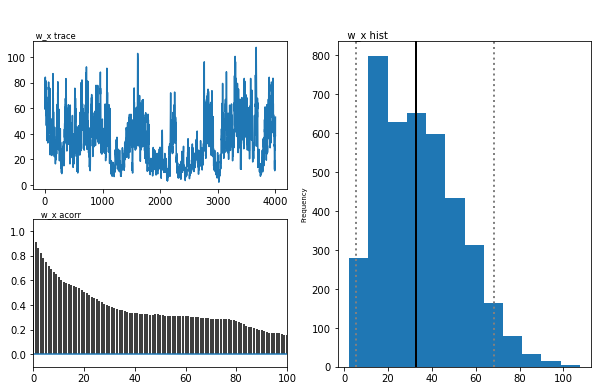

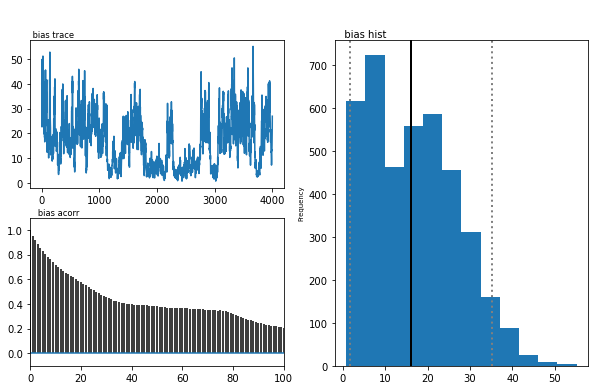

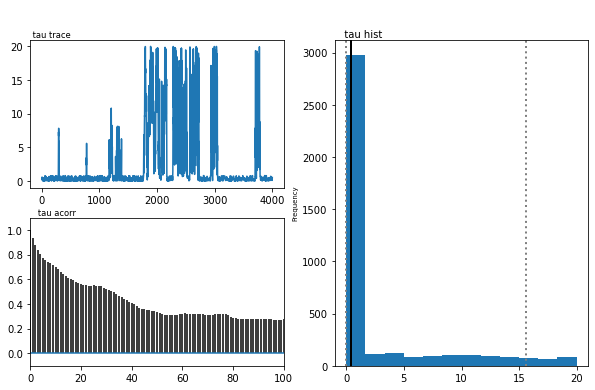

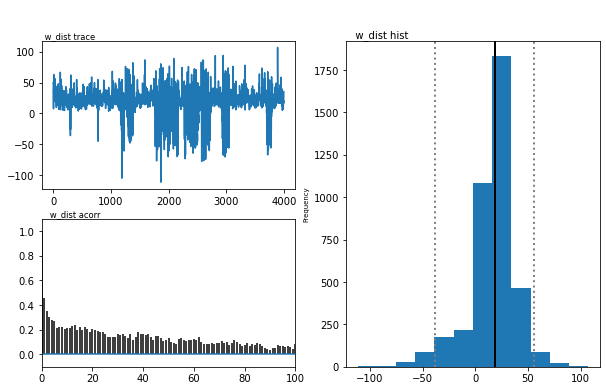

In [84]:
model = pm.Model([obs, w_dist, w_x, tau, bias, p])
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(50000, 30000, 5)
import pymc.Matplot as mcplot
mcplot.plot(mcmc)

In [107]:
tau_samples = mcmc.trace("tau")[:].reshape(1, -1)
w_x_samples = mcmc.trace("w_x")[:].reshape(1, -1)
w_dist_samples = mcmc.trace("w_dist")[:].reshape(1, -1)
bias_samples = mcmc.trace("bias")[:].reshape(1, -1)

In [130]:
n = 100
dist = np.linspace(0, 20, n)
x = np.ones(n) * 0.9

In [131]:
def get_res(dist, x):
    dist = dist.reshape(-1, 1)
    x = x.reshape(-1, 1)
    return 1 / (1 + np.exp(-((dist >= tau_samples) * w_dist_samples * dist + w_x_samples * x) + bias_samples))

In [132]:
res = get_res(dist, x)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


In [139]:
res.shape

(100, 4000)

In [133]:
low, high = np.quantile(res, [0.025, 0.975], axis=1)
mean = res.mean(axis=1)

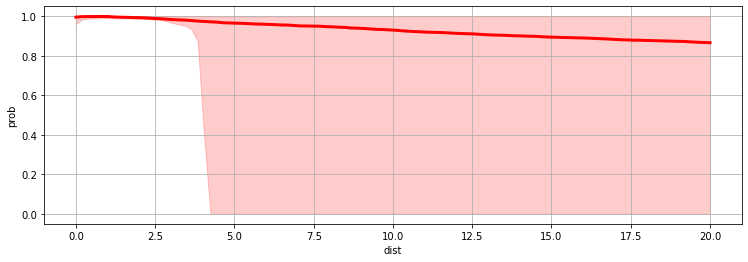

In [140]:
plt.figure(figsize=(12.5, 4))
plt.plot(dist, mean, color="red", label="mean", lw=3)
plt.fill_between(dist, low, high, color="red", alpha=0.2)
plt.xlabel("dist")
plt.ylabel("prob")
plt.grid()